# AIM
- copy of another notebook `baseline_model_mar23_pipeline`
- same routine. more tuning.
- run more baseline models with sklearn pipeline
- input data: data with preprocessed routine as of Mar22

Created: 23 Mar 2022

# LIBRARIES

In [1]:
##### MODULES
import os
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
import matplotlib.dates
import matplotlib.patches
import datetime as dt
import ast

## custom modules
# import sys  
# sys.path.append('../../scripts')

import import_data
import clean_data
import mappings
import plotting
import report
import helper

##### OPTIONS
pd.options.mode.chained_assignment = None

# autoreload external modules after saving changes to disk
%reload_ext autoreload
%autoreload 2

##### DIRECTORIES
proj_dir = Path('.') / '..' / '..'
source_data_dir = proj_dir/'data'/'source'
clean_data_dir =  proj_dir/'data'/'clean'
viz_dir = proj_dir/'viz'

In [2]:
import random
from pprint import pprint
import feather

ML libraries

In [3]:
from sklearn.model_selection import train_test_split

# preprocessing
from sklearn.preprocessing import StandardScaler


# classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import svm

# tune
from sklearn.model_selection import GridSearchCV

# performance
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# pipe
from sklearn.pipeline import Pipeline

# PARAMETERS

In [4]:
PATH_TO_PREPROCESSED_DATA = proj_dir/'data'/'clean'/'preprocessMar22'/'data_merge2.ftr'
PATH_TO_FEATURES_SELECTED = proj_dir/'data'/'clean'/'fsMar23all'/'feat_tsfresh_select.ftr'

SEED = 123

### INITIAL SPLIT
TEST_SIZE = 0.3

### TUNING
N_JOBS = -2 # all but 1 CPUs
KFOLD = 5
SCORING = 'balanced_accuracy'

### CROSS VALIDATION
N_SPLITS = 5
N_REPEATS = 3

In [5]:
tune_defaults = {
    "n_jobs": N_JOBS,
    "cv": KFOLD,
    "scoring": SCORING,
    "return_train_score": True
}

# IMPORT

In [6]:
fs = pd.read_feather(PATH_TO_FEATURES_SELECTED)
df = pd.read_feather(PATH_TO_PREPROCESSED_DATA)

In [7]:
df['target'] = df['phq'] > 10
_, y = clean_data.generate_ts_y(df)
y = y[fs['index']]

# check index does match
if np.array_equal(y.index.values, fs['index'].values):
    print("Primary key does match.")

Primary key does match.


In [8]:
X = fs.loc[:, fs.columns != 'index'].copy()

# TRAIN TEST SPLIT

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED, test_size=TEST_SIZE)

report.report_train_test_split(X_train, X_test, y_train, y_test)

Training Features Shape: (2002, 422)
Training Labels Shape: (2002,)
Testing Features Shape: (858, 422)
Testing Labels Shape: (858,)


# PIPELINE

## Tuning routine

In [10]:
def tune_hyperparameters(pipeline, params, tune_defaults=False):
    
    grid_search = GridSearchCV(pipeline, params)
    if tune_defaults:
        grid_search.set_params(**tune_defaults)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(params)

    ### fit
    grid_search.fit(X_train, y_train)
    grid_search.cv_results_.keys()

    return grid_search

KNN - standard scaling

In [11]:
params_knn = dict()
params_knn['knn__n_neighbors']=(3, 5, 7, 9, 11, 13, 15)

pipeline_knn_std = Pipeline(
    [
        ('scaler', StandardScaler()), 
        ('knn', KNeighborsClassifier())   
    ]
)

with helper.Timer("Tune: KNN"):
    search_knn_std = tune_hyperparameters(pipeline_knn_std, params_knn, tune_defaults=tune_defaults)
search_knn_std.best_params_

# [Tune: KNN]
Performing grid search...
pipeline: ['scaler', 'knn']
parameters:
{'knn__n_neighbors': (3, 5, 7, 9, 11, 13, 15)}
Elapsed: 10.2 seconds


{'knn__n_neighbors': 9}

SVC - standard scaling

In [12]:
params_svc = dict()
params_svc['svc__C'] = (0.1, 1, 10, 100, 1000)
params_svc['svc__gamma'] = (1, 0.1, 0.01, 0.001, 0.0001)
params_svc['svc__kernel'] = ['rbf']

# params_svc = dict()
# params_svc['svc__C'] = (1, 100)
# params_svc['svc__gamma'] = (0.1, 0.001)
# params_svc['svc__kernel'] = ['rbf']


pipeline_svc_std = Pipeline(
    [
        ('scaler', StandardScaler()), 
        ('svc', svm.SVC())   
    ]
)
with helper.Timer("Tune: SVC"):
    search_svc_std = tune_hyperparameters(pipeline_svc_std, params_svc, tune_defaults=tune_defaults)
search_svc_std.best_params_


# [Tune: SVC]
Performing grid search...
pipeline: ['scaler', 'svc']
parameters:
{'svc__C': (0.1, 1, 10, 100, 1000),
 'svc__gamma': (1, 0.1, 0.01, 0.001, 0.0001),
 'svc__kernel': ['rbf']}
Elapsed: 133.5 seconds


{'svc__C': 10, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}

RF - no scaling

In [18]:
params_rf = dict()
params_rf['rf__n_estimators'] = (10, 50, 100, 200)
params_rf['rf__min_samples_split'] = (2, 5)
params_rf['rf__max_features'] = ["auto", "sqrt"]
params_rf['rf__max_depth'] = [2] + [5] + [int(x) for x in np.linspace(10, 110, num = 11)] + [None]
# params_rf['rf__min_samples_leaf'] = 4


pipeline_rf = Pipeline(
    [ 
        ('rf', RandomForestClassifier(random_state=SEED))   
    ]
)
with helper.Timer("Tune: RF"):
    search_rf = tune_hyperparameters(pipeline_rf, params_rf, tune_defaults)
search_rf.best_params_

# [Tune: RF]
Performing grid search...
pipeline: ['rf']
parameters:
{'rf__max_depth': [2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'rf__max_features': ['auto', 'sqrt'],
 'rf__min_samples_split': (2, 5),
 'rf__n_estimators': (10, 50, 100, 200)}
Elapsed: 664.2 seconds


{'rf__max_depth': 20,
 'rf__max_features': 'auto',
 'rf__min_samples_split': 2,
 'rf__n_estimators': 200}

Logistic regression, regularized

In [14]:
from sklearn.linear_model import LogisticRegression

#! add prefix
params_lr = dict()
params_lr['logistic__solver'] = ['newton-cg', 'lbfgs', 'liblinear']
params_lr['logistic__penalty'] = ['none', 'l1', 'l2', 'elasticnet']
params_lr['logistic__C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]

pipeline_lr = Pipeline(
    [ 
        ('logistic', LogisticRegression())   
    ]
)
with helper.Timer("Tune: logistic"):
    search_lr = tune_hyperparameters(pipeline_lr, params_lr, tune_defaults)
    
search_lr.best_params_

# [Tune: SVC]
Performing grid search...
pipeline: ['logistic']
parameters:
{'logistic__C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
 'logistic__penalty': ['none', 'l1', 'l2', 'elasticnet'],
 'logistic__solver': ['newton-cg', 'lbfgs', 'liblinear']}


C:\Users\Harris\anaconda3\envs\msc-thesis\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
240 fits failed out of a total of 480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Harris\anaconda3\envs\msc-thesis\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Harris\anaconda3\envs\msc-thesis\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Harris\anaconda3\envs\msc-thesis\lib\site-packages\sklearn\linear_model\_logistic.py", li

Elapsed: 469.5 seconds


{'logistic__C': 0.1,
 'logistic__penalty': 'l1',
 'logistic__solver': 'liblinear'}

# Visualize tuning results

In [19]:
from sklearn.metrics import balanced_accuracy_score

searches = [search_knn_std, search_svc_std, search_rf, search_lr]
names = ['knn', 'svc', 'rf', 'logistic']

for name, search in zip(names, searches):
    print(f"### {name}")
    print(f"Best score: {search.best_score_}")
    print(f'Best params: {search.best_params_}')
    if len(search.best_params_)>1:
        pass
        # plotting.plot_search_results(search)

### knn
Best score: 0.6361371153306452
Best params: {'knn__n_neighbors': 9}
### svc
Best score: 0.644029916331013
Best params: {'svc__C': 10, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
### rf
Best score: 0.6363237836379443
Best params: {'rf__max_depth': 20, 'rf__max_features': 'auto', 'rf__min_samples_split': 2, 'rf__n_estimators': 200}
### logistic
Best score: 0.6189314284232641
Best params: {'logistic__C': 0.1, 'logistic__penalty': 'l1', 'logistic__solver': 'liblinear'}


# Model fitting

In [20]:
def combine_classification_reports(report_dicts, names):
    
    results = []
    for report_dict, name in zip(report_dicts, names):
        df = pd.DataFrame(report_dict).transpose().reset_index(level=0)
        df.loc[df['index']=='accuracy', ['precision', 'recall']] = None

        support = df.loc[df['index']=='macro avg', 'support'].values
        df.loc[df['index']=='accuracy', 'support'] = support
        
        df['name'] = name
        
        df = df[['name','index','precision','recall','f1-score', 'support']]
        results.append(df)

    combined = pd.concat(results)
    return combined

##############

y_preds = []

for name, search in zip(names, searches):
    print(f"### {name}")

    # fit
    pipeline = search.best_estimator_
    y_pred = pipeline.predict(X_test)
    y_preds.append(y_pred) 


dicts = [classification_report(y_test, y_pred, output_dict=True) for y_pred in y_preds]
df = combine_classification_reports(dicts, names)
df.to_excel(proj_dir/"data"/"artefacts"/"baseline_models_moretuning.xlsx")
df

### knn
### svc
### rf
### logistic


,name,index,precision,recall,f1-score,support
0,knn,False,0.617133,0.736952,0.671741,479.0
1,knn,True,0.559441,0.422164,0.481203,379.0
2,knn,accuracy,NaN,NaN,0.597902,858.0
3,knn,macro avg,0.588287,0.579558,0.576472,858.0
4,knn,weighted avg,0.591649,0.597902,0.587576,858.0
0,svc,False,0.687379,0.739040,0.712274,479.0
1,svc,True,0.635569,0.575198,0.603878,379.0
2,svc,accuracy,NaN,NaN,0.666667,858.0
3,svc,macro avg,0.661474,0.657119,0.658076,858.0
4,svc,weighted avg,0.664493,0.666667,0.664393,858.0


# Feature importance from RF

# [Permutation feature importance]
Elapsed: 105.9 seconds


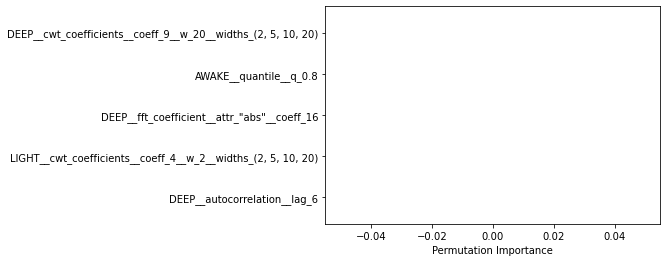

In [25]:
rf_best = search_rf.best_estimator_

from sklearn.inspection import permutation_importance

with helper.Timer("Permutation feature importance"):
    perm_importance = permutation_importance(rf_best, X_train, y_train, n_jobs=-2)

plotting.plot_imp_perm(perm_importance, features=X_train.columns, n=5)

<AxesSubplot:ylabel='Frequency'>

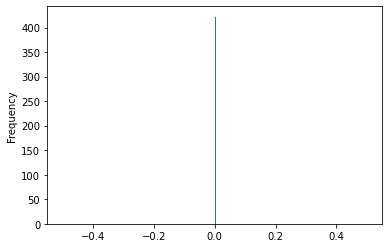

In [36]:
pd.Series(perm_importance['importances_mean']).plot.hist(bins=200);

In [ ]:
df = pd.read_feather(proj_dir/"data"/"clean"/"preprocessMar22"/"data_merge2.ftr")

report.report_preprocessed(df)

In [46]:
y.value_counts()

False    1628
True     1232
Name: target, dtype: int64

In [48]:
y_train.value_counts()

False    1149
True      853
Name: target, dtype: int64

In [56]:
import pickle

for name, search in zip(names, searches):
    model = search.best_estimator_
    filename = 'baseline_model_' + name + '.pickle'
    path = proj_dir/'data'/'artefacts'/filename
    print(path)
    pickle.dump(model, open(path, 'wb'))

..\..\data\results\baseline_model_knn.pickle
..\..\data\results\baseline_model_svc.pickle
..\..\data\results\baseline_model_rf.pickle
..\..\data\results\baseline_model_logistic.pickle
